In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import sys
sys.path.append('../src')  # Add the path to where the python scripts are located
from constants import *
from radiative import *
from utils import *
from plot_utils import nice_fonts  

In [17]:
def PlotModels(models_abs, models_unabs, title, figureName):
    fig, ax = plt.subplots()
    plt.title(title)
    ax.set_xlabel(r'$\nu$ [Hz]')
    ax.set_ylabel(r'$S_\nu$ [Jy]')
    xmin, xmax = 1e11, 2e16
    ymin, ymax = 1e-4, 2e6
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    m = len(models_abs)
    color_vector = np.linspace(0.05,0.95,m)
    colors = plt.cm.copper_r(color_vector) 
    # plt.plot(nu,S1)
    # SBB = Snu_BB(nu, T_beam, R_beam , D)
    # plt.plot(nu,SBB)
    for i in range(0,m):
        plt.plot(models_abs[i][0],models_abs[i][1],label=models_abs[i][2],color=colors[i])
        plt.plot(models_unabs[i][0],models_unabs[i][1],label=None,color=colors[i], ls='dotted')
    
    bands = [{'name': 'FUV', 'start': 1.947e15, 'width': 7.335e14, 'color': 'purple', 'pos': ymin + (ymax-ymin)/1E1},
         {'name': 'NUV', 'start': 1.295e15, 'width': 4.631e14, 'color': 'purple', 'pos': ymin + (ymax-ymin)/1E1},
         #{'name': 'U', 'start': 7.498e14, 'width': 1.0e14, 'color': 'violet', 'pos': ymin + (ymax-ymin)/2.},
         #{'name': 'B', 'start': 6.0e14, 'width': 1.0e14, 'color': 'blue', 'pos': ymin + (ymax-ymin)/5.},
         {'name': 'V', 'start': 5.0e14, 'width': 1.0e14, 'color': 'green', 'pos': ymin + (ymax-ymin)/10.},
         {'name': '300GHz', 'start': 3.0e11, 'width': 6.0e10, 'color': 'blue', 'pos': ymin + (ymax-ymin)/1E2},
         {'name': '950GHz', 'start': 9.5e11, 'width': 3.0e11, 'color': 'purple', 'pos': ymin + (ymax-ymin)/1E2},         
         {'name': r'$9.8\,\mu\mathrm{m}$', 'start': 3.06e13, 'width': 1.0e13, 'color': 'red', 'pos': ymin + (ymax-ymin)/1E1},
    ]
    for band in bands:
        # Add the rectangle
        ax.add_patch(Rectangle((band['start'], ymin), band['width'], ymax-ymin,
                           edgecolor='none', facecolor=band['color'], alpha=0.1, lw=0))
        # Add the vertical dashed line with the text
        ax.axvline(band['start'] + band['width']/2, ymin=0, ymax=1, color=band['color'], alpha=0.2, linestyle='--')
        ax.text(band['start']*2.5, band['pos'], band['name'], color=band['color'],
            ha='right', va='center', rotation='vertical', fontsize=13)
#         ax.text(band['start'] + 3*band['width'], band['pos'], band['name'], color=band['color'],
#             ha='right', va='center', rotation='vertical', fontsize=13)

    ax.loglog() 
    ax.legend()
    plt.show()
    fig.savefig(figureName)

R_beam/R_s=4.986666666666666


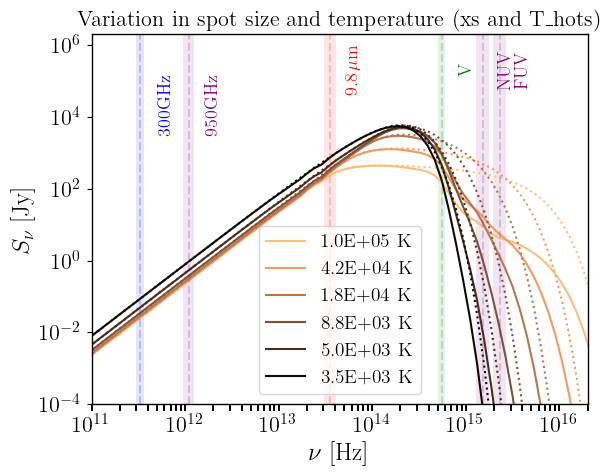

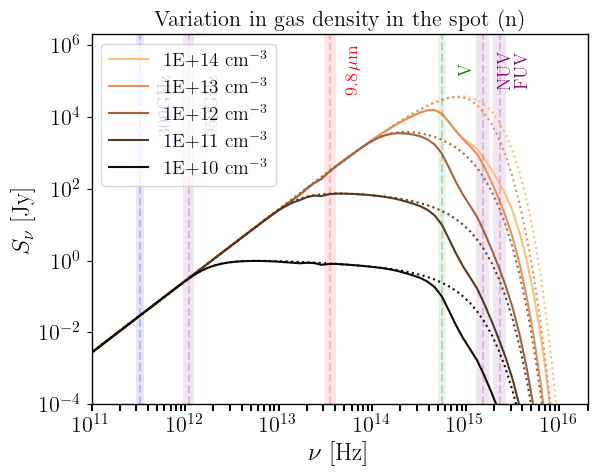

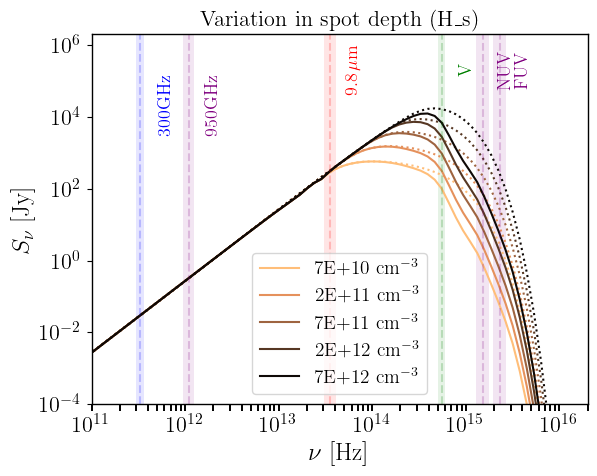

In [18]:
T_star = 2500 # K
T_beam = 3500 # K , measured brightness temperature in the beam with the hot spot
R_beam = 0.5 * au  # Beam size, to be updated
nu  = np.logspace(10.5,18,100)
R_s = 1.5E12
R_star = 2.5E13
H_s = R_beam*0.1
D   = 1.543e+20
n   = 1E12
print(f'{R_beam/R_s=}')

Mdot_dust = 3e-10 # in Msun/yr
vExp = 10         # in km/s
Rin = 5.0         # in au
Rout = 1e6        # in au
kappaFile = "0.09mu-0.11mu_MgFeSiO4_dens_HSD_new.opacity"

# x is the normalized size of the hot spot
x_min = 0.1        # Arbitrary
x_max = 1.0        # R_beam/R_star

xs = np.geomspace(x_min, x_max, 6) 
color_vector = np.linspace(0.05,0.95,len(xs))
colors = plt.cm.copper_r(color_vector) 

# The temperature of the hot spot has to be consistent with the assumed stellar temperature 
# and the average temperature measured in the beam (T_beam). When x=x_max, T_hot = T_beam
T_hots = np.ones_like(xs) # just to have the same dimension
models_abs = []
models_unabs = []
for i in range(0,len(xs)):
    T_hots[i] = T_star + (T_beam - T_star)/xs[i]**2
    S_Jy_unabs = S_ff(nu=nu, R=R_beam*xs[i], D=D, Te=T_hots[i], n=n, H=H_s)
    S_Jy = S_ff_abs(nu=nu, R=R_beam*xs[i], D=D, Te=T_hots[i], n=n, H=H_s,
                       Mdot_dust=Mdot_dust, vExp=vExp, Rin=Rin, Rout=Rout, kappaFile=kappaFile)                                      
    models_abs.append([nu,S_Jy,'%.1E' %T_hots[i]+" K"])                                     
    models_unabs.append([nu,S_Jy_unabs,'%.1E' %T_hots[i]+" K"])

models2_abs = []
models2_unabs = []
T_hotSpot = 15000.0
n_vec = [1E14,1E13,1E12,1E11,1E10]
xs_15000K = 0.28284
T_hots_15000K = T_star + (T_beam - T_star)/xs_15000K**2
for i in range(0,len(n_vec)):
    S_Jy_unabs = S_ff(nu=nu, R=R_beam*xs_15000K, H=H_s, D=D, Te=T_hots_15000K, n=n_vec[i])
    S_Jy = S_ff_abs(nu=nu, R=R_beam*xs_15000K, H=H_s, D=D, Te=T_hots_15000K, n=n_vec[i],
                       Mdot_dust=Mdot_dust, vExp=vExp, Rin=Rin, Rout=Rout, kappaFile=kappaFile)
    models2_abs.append([nu,S_Jy,'%.0E' % n_vec[i]+" cm$^{-3}$"])                          
    models2_unabs.append([nu,S_Jy_unabs,'%.0E' % n_vec[i]+" cm$^{-3}$"])

models3_abs = []
models3_unabs = []
H_s_range = [0.1,0.316,1.0,3.16,10.0]
for i in range(0,len(H_s_range)):
    S_Jy_unabs = S_ff(nu, R=R_beam*xs_15000K, H=H_s*H_s_range[i], D=D, Te=T_hots_15000K, n=n)
    S_Jy = S_ff_abs(nu, R=R_beam*xs_15000K, H=H_s*H_s_range[i], D=D, Te=T_hots_15000K, n=n,
                       Mdot_dust=Mdot_dust, vExp=vExp, Rin=Rin, Rout=Rout, kappaFile=kappaFile)
    models3_abs.append([nu,S_Jy,'%.0E' % (H_s_range[i]*H_s)+" cm$^{-3}$"])                       
    models3_unabs.append([nu,S_Jy_unabs,'%.0E' % (H_s_range[i]*H_s)+" cm$^{-3}$"])
    
    
PlotModels(models_abs, models_unabs,"Variation in spot size and temperature (xs and T_hots)","Fig_xs_and_Thots.pdf")
PlotModels(models2_abs, models2_unabs,"Variation in gas density in the spot (n)","Fig_density.pdf")
PlotModels(models3_abs, models3_unabs,"Variation in spot depth (H_s)","Fig_depth.pdf")